**Clustering:**
Dans cette partie, nous récupérons le dataset crée par "prepare_data" afin d'y appliquer deux méthodes de machine learning pour deux buts différents:

**1- l'analyse de composantes principales (PCA):** Cette méthode est utilisée pour réduire la dimentionalité du dataset. D'une part, cela nous permet d'essayer de faire un clustering sur deux dimentions, d'autre part, elle nous permet d'identifier quelles variables séparent mieux le dataset.

**2- le clustering par la méthode des knn:** C'est la méthode de clustering qu'on a choisi d'utiliser, pricipalement car on l'a vu en cours, elle est appliquée sur les données de dimention réduite (par la PCA)

Préparation de l'environnement: rien d'exceptionnel ici, on importe les bibliothèques dont on aura besoin

In [124]:
!pip install geopandas

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import seaborn as sns
from scipy import stats

Lecture du dataset:

In [126]:
camping=pd.read_csv("camping.csv")

Vérification des colonnes (on a remarqué ici qu'une nouvelle colonne est ajoutée par le code précédent qui n'a aucune utilité appelée "Unnamed: 0", sans vouloir trop modifier le code précédent, on se contente de l'enlever)

In [127]:
camping.columns

Index(['Unnamed: 0', 'Adresse', 'dep', 'Emplacements', 'Nom', 'Classement',
       'commune', 'code_postal', 'geometry', 'Surface', 'permanence_24h',
       'langues_accueil', 'internet_partout', 'rapport_sans_mobile',
       'distance_police', 'distance_hopitaux', 'defib_moins_2km'],
      dtype='object')

La variable "rapport_sans_mobile" est obsolète car tous les sites de camping ont une couverture réseau totale, on l'enlève aussi

In [128]:
camping_copy=camping.drop(columns=["Unnamed: 0","rapport_sans_mobile"])
camping_copy

,Adresse,dep,Emplacements,Nom,Classement,commune,code_postal,geometry,Surface,permanence_24h,langues_accueil,internet_partout,distance_police,distance_hopitaux,defib_moins_2km
0,Route du Château d'eau,78,180,CAMPING HUTTOPIA RAMBOUILLET,3,RAMBOUILLET,78120,POINT (1.835694 48.630059),18000.0,1,3,0,2817,6807,0
1,11 CHEMIN DU CAMPING,77,440,CAMPING LES PRÉS DE LA FONTAINE,3,HERMÉ,77114,POINT (3.338549 48.472784),44000.0,1,3,0,4953,10485,1
2,26 Route de Vauvert,91,230,CARAVANING LE VAUVERT,4,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),28750.0,1,3,1,5177,691,1
3,chemin des ponceaux,77,140,CAMPING LES ACACIAS,2,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),14000.0,0,1,0,16466,23260,0
4,24 Place de la gare de Faremoutiers,77,316,LE CHÊNE GRIS,4,POMMEUSE,77515,POINT (2.99998 48.800512),39500.0,1,3,1,8711,12013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,7 route de Mary prolongée,77,29,CAMPING DES 2 ÎLES,3,ISLES-LES-MELDEUSES,77440,POINT (3.017345 49.005719),2900.0,1,3,0,7302,17542,0
61,route des grandes vallées,91,200,CAMPING LA MUSARDIÈRE,3,MILLY-LA-FORÊT,91490,POINT (2.50748 48.395017),20000.0,1,3,0,5808,17766,1
62,route de Chatenay,77,75,L'ÉTANG DE L'HERMITAGE,1,LA TOMBE,77130,POINT (3.092168 48.393756),7500.0,0,1,0,7144,13471,0
63,25 ter rue de ballancourt,91,190,CAMPING LE NID VERT,3,MONDEVILLE,91590,POINT (2.413052 48.492246),19000.0,1,3,0,10911,27601,0


On réorganise les colonnes du dataset afin de faciliter les manipulations qui vont suivre

In [129]:
camping_copy.columns

Index(['Adresse', 'dep', 'Emplacements', 'Nom', 'Classement', 'commune',
       'code_postal', 'geometry', 'Surface', 'permanence_24h',
       'langues_accueil', 'internet_partout', 'distance_police',
       'distance_hopitaux', 'defib_moins_2km'],
      dtype='object')

In [130]:
camping_copy=camping_copy[['Adresse', 'dep', 'Nom', 'commune',
       'code_postal', 'geometry','Emplacements', 'Surface', 'permanence_24h',
       'distance_police','distance_hopitaux','defib_moins_2km','langues_accueil','internet_partout', 'Classement']]

In [131]:
#camping_copy=camping_copy.drop(columns=["label"],axis=1)

On enlève les données abérrantes, ils influent négativement sur le résultat du clustening car la méthode des knn est sensible à ce type de données

On a choisit d'utiliser le "zscore" pour les identifier car c'est la métrique qui nous semble la plus intuitive: on enlève les lignes dont les valeurs dépassent la moyenne par 3 écart-types

In [132]:
camping_copy_clean=camping_copy[(np.abs(stats.zscore(camping_copy.iloc[:,6:14].values)) < 3).all(axis=1)]

In [133]:
camping_copy_clean

,Adresse,dep,Nom,commune,code_postal,geometry,Emplacements,Surface,permanence_24h,distance_police,distance_hopitaux,defib_moins_2km,langues_accueil,internet_partout,Classement
0,Route du Château d'eau,78,CAMPING HUTTOPIA RAMBOUILLET,RAMBOUILLET,78120,POINT (1.835694 48.630059),180,18000.0,1,2817,6807,0,3,0,3
1,11 CHEMIN DU CAMPING,77,CAMPING LES PRÉS DE LA FONTAINE,HERMÉ,77114,POINT (3.338549 48.472784),440,44000.0,1,4953,10485,1,3,0,3
2,26 Route de Vauvert,91,CARAVANING LE VAUVERT,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),230,28750.0,1,5177,691,1,3,1,4
3,chemin des ponceaux,77,CAMPING LES ACACIAS,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),140,14000.0,0,16466,23260,0,1,0,2
4,24 Place de la gare de Faremoutiers,77,LE CHÊNE GRIS,POMMEUSE,77515,POINT (2.99998 48.800512),316,39500.0,1,8711,12013,1,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,7 route de Mary prolongée,77,CAMPING DES 2 ÎLES,ISLES-LES-MELDEUSES,77440,POINT (3.017345 49.005719),29,2900.0,1,7302,17542,0,3,0,3
61,route des grandes vallées,91,CAMPING LA MUSARDIÈRE,MILLY-LA-FORÊT,91490,POINT (2.50748 48.395017),200,20000.0,1,5808,17766,1,3,0,3
62,route de Chatenay,77,L'ÉTANG DE L'HERMITAGE,LA TOMBE,77130,POINT (3.092168 48.393756),75,7500.0,0,7144,13471,0,1,0,1
63,25 ter rue de ballancourt,91,CAMPING LE NID VERT,MONDEVILLE,91590,POINT (2.413052 48.492246),190,19000.0,1,10911,27601,0,3,0,3


Ici la partie ACP, le code a été repris d'internet et il est assez décortiqué

In [134]:
X=camping_copy.iloc[:,6:14].values  #récupération des données numériques du dataset
X=X[(np.abs(stats.zscore(X)) < 3).all(axis=1)] #puisque on travaille sur le dataset contenant les données abérrantes, on les enlève aussi de la même manière
y=camping_copy.iloc[:,-1].values #on récupère la colonne du "classement" des sites de camping, afin de l'utiliser comme variable illustrative
from sklearn.preprocessing import StandardScaler, QuantileTransformer,MaxAbsScaler #on a essayé plusieurs preprocess pour les données, le QantileTransformer nous semble le plus adéquat
X_std = QuantileTransformer().fit_transform(X) #normalisation des données
#calculs d'algèbre linéaire: matrice de covariance puis ses valeurs propres et vecteurs propres afin d'avoir la base orthogonale de l'analyse en composantes principales
cov_mat= np.cov(X_std, rowvar=False)
cov_mat = np.cov(X_std.T) 
eig_vals, eig_vecs = np.linalg.eig(cov_mat) 
print('Vecteurs Propres \n%s' %eig_vecs) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
#eig_pairs.reverse() 
#print("\n",eig_pairs) 
#for i in eig_pairs: 
#  print(i[0])
#tot = sum(eig_vals) 
#print("\n",tot) 
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
#print("\n\n1. Variance Explained\n",var_exp) 
cum_var_exp = np.cumsum(var_exp) 
print("\n\n2. Cumulative Variance Explained\n",cum_var_exp)
#print("\n\n3. Percentage of variance the first two principal components each contain\n ",var_exp[0:2]) 
#print("\n\n4. Percentage of variance the first two principal components together contain\n",sum(var_exp[0:2]))
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1), eig_pairs[1][1].reshape(8,1)))
Y = X_std.dot(matrix_w) 
principalDf = pd.DataFrame(data = Y , columns = ['principal component 1', 'principal component 2']) 
principalDf.head()
finalDf = pd.concat([principalDf,pd.DataFrame(y,columns = ['Classement'])], axis = 1) 
finalDf.head()

Vecteurs Propres 
[[ 2.97580833e-01  1.29740201e-01 -3.70869624e-01 -4.24798132e-02
   5.27147381e-01  1.26041619e-02 -6.89801476e-01 -3.73498852e-02]
 [ 3.09418921e-01  1.25379445e-01 -3.73244985e-01 -8.15507286e-02
   4.70898862e-01  3.02460852e-03  7.20066320e-01  4.82410046e-02]
 [ 6.80890451e-01 -9.15023798e-02  3.16948016e-01  2.26373046e-01
  -1.31817433e-01  1.58702260e-02 -4.06188905e-02  5.97525827e-01]
 [ 3.01235979e-03 -2.78298704e-01  2.81240020e-01 -4.49910843e-01
   2.10948962e-01  7.72349282e-01  7.05192038e-04  1.29061912e-03]
 [-1.62651775e-02 -1.06390261e-01  5.04826250e-01 -4.86428904e-01
   3.62430064e-01 -6.04463425e-01 -3.35168497e-03  1.45298933e-02]
 [ 2.95010481e-02  9.29677674e-01  2.88695955e-01 -1.48957574e-01
  -6.12296901e-02  1.59712762e-01 -2.01697782e-03 -5.83847242e-03]
 [ 5.19746930e-01 -7.63799431e-02  2.30528716e-01  1.42605783e-01
  -9.95733467e-02 -1.93049805e-03  4.42705839e-02 -7.99168863e-01]
 [ 2.84276204e-01 -1.30866337e-02 -3.90196776e-01 -

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (63). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


,principal component 1,principal component 2,Classement
0,1.479834,-0.071148,3
1,1.697848,0.866064,3
2,1.904800,0.844954,4
3,0.284296,-0.235469,2
4,1.952148,0.758448,4


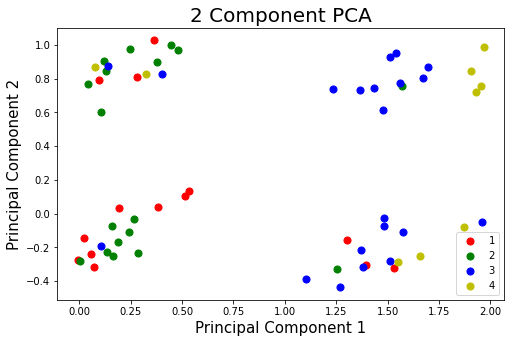

In [135]:
fig = plt.figure(figsize = (8,5)) 
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15) 
ax.set_ylabel('Principal Component 2', fontsize = 15) 
ax.set_title('2 Component PCA', fontsize = 20) 
targets = [1, 2,3,4]#,3,4]
colors = ['r', 'g', 'b', 'y'] 
for target, color in zip(targets,colors): 
    indicesToKeep = finalDf['Classement'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'] , finalDf.loc[indicesToKeep, 'principal component 2'] , c = color , s = 50) 
    ax.legend(targets) 
    ax.grid()

In [136]:
xvars = ['principal component 1', 'principal component 2'] #'permanence_24h','distance_police','distance_hopitaux','defib_moins_2km','langues_accueil','internet_partout']
df2 = finalDf[xvars].dropna()

In [137]:
df2

,principal component 1,principal component 2
0,1.479834,-0.071148
1,1.697848,0.866064
2,1.904800,0.844954
3,0.284296,-0.235469
4,1.952148,0.758448
...,...,...
58,1.101671,-0.387776
59,1.570609,0.753342
60,0.105875,-0.188854
61,1.509056,-0.278318


In [138]:
df2_copy=camping_copy_clean

In [139]:
distortions = []
K = range(1,10)
for k in K:
  model = KMeans(n_clusters=k)
  model.fit(df2[xvars])
  distortions.append(model.inertia_)

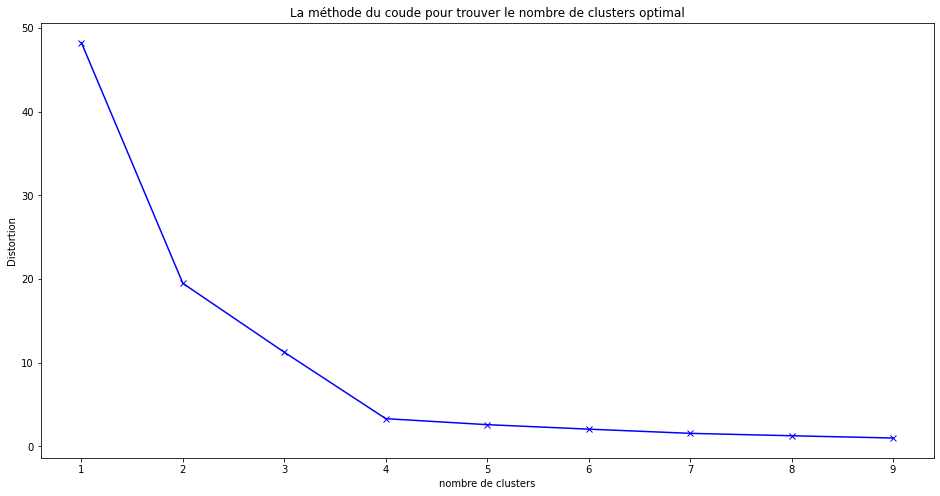

In [140]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('nombre de clusters')
plt.ylabel('Distortion')
plt.title('La méthode du coude pour trouver le nombre de clusters optimal')
plt.show()

In [141]:
model = KMeans(n_clusters=4)
model.fit(df2[xvars])

KMeans(n_clusters=4)

In [142]:
df2_copy['label'] = model.labels_
df2_copy['label'].head(45)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0     1
1     3
2     3
3     2
4     3
5     2
6     1
7     2
8     3
9     2
10    1
11    0
12    1
13    3
14    1
15    3
16    2
17    3
18    0
19    3
20    0
21    2
22    1
23    0
24    1
25    1
26    2
27    1
28    2
29    3
30    3
31    3
32    2
34    2
35    1
36    0
37    0
38    1
39    1
40    0
41    2
42    2
43    0
44    2
45    0
Name: label, dtype: int32

In [143]:
from geopandas import GeoDataFrame

df2_copy = GeoDataFrame(df2_copy)

In [144]:
finalDf=finalDf.dropna()

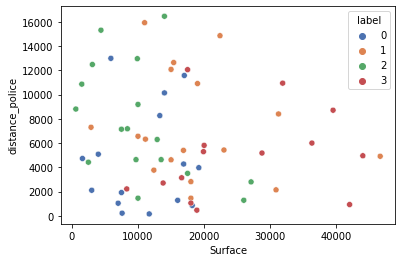

In [145]:
plt.figure()
p = sns.scatterplot(data=df2_copy, x="Surface", y="distance_police", hue = "label", palette="deep", alpha = 1)
#p.set(xscale="log")

In [146]:
camping_copy_clean.to_csv("camping_labelled.csv")